# Python for Quant Finance

## how to build an energy trading business from scratch
###Dr. Teodora Baeva

<img src='btg_ataglance.png' width="1000">

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


## What does a quant do in commodities trading?

* model development
* portfolio optimisation
* trading strategies
* pricing of complex products (storage, tolling, swing contracts)

## Example: Gas storage

* natural gas can be stored
* used to 
  - meet load variations
  - speculation (buy low, store, sell high)
* subject to physical constraints...
  - injection and withdrawal rate depend on time and current amount of gas stored
  - minimum and maximum storage capacity can vary with time
* ...find an optimal strategy

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

start_date = datetime(2015, 7, 1)
end_date = datetime(2016, 7, 1)
dates = pd.date_range(start_date, end_date)

max_inventory = pd.TimeSeries(3640, index=dates)
max_inventory[10:] = 3200
min_inventory = pd.TimeSeries(0, index=dates)
min_inventory[10:] = 200
with_rate = pd.Series([2, 4, 8, 15, 23, 30, 35, 38, 40, 42, 43, 43], 
                      index=[0, 1300, 1550, 2000, 2150, 2550, 2800, 3100, 3150, 3200, 3350, 3600])
inj_rate  = pd.Series([27, 26, 25, 24, 23, 22, 21, 20, 17, 11, 10, 5], 
                      index=[0, 1300, 1550, 2000, 2150, 2550, 2800, 3100, 3150, 3200, 3350, 3600])
wth_rate_constraints = pd.DataFrame({'min': pd.Series(2, index=dates),
                                     'max': pd.Series(45, index=dates),
                                    })
inj_rate_constraints = pd.DataFrame({'min': pd.Series(2, index=dates),
                                     'max': pd.Series(26, index=dates),
                                    })

In [3]:
storage_params = {'name': 'TestStorage',
                  'start_inventory': 2500, 
                  'max_inventory': max_inventory,
                  'min_inventory': min_inventory,
                  'with_rate': with_rate,
                  'inj_rate': inj_rate,
                  'inj_cost': 0,
                  'with_cost': 0,
                  'end_inventory': 2500,
                  'storage_start_date': start_date,
                  'storage_end_date': end_date,
                  'wth_rate_constraints': wth_rate_constraints,
                  'inj_rate_constraints': inj_rate_constraints,
                 }

In [4]:
import btglib.quant.models.storage as sc

storage = sc.Storage(storage_params)

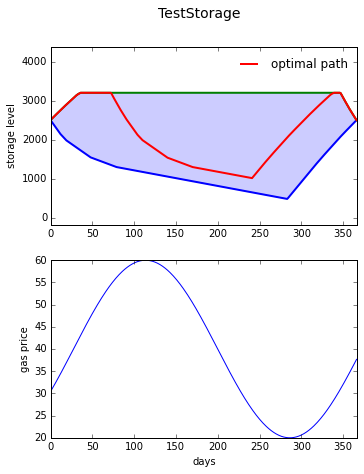

In [5]:
curve = 20*pd.Series(np.sin(np.linspace(0,10,len(dates))/1.5-0.5), index=dates)+40

storage.optimize(curve, curve)
storage.plot();

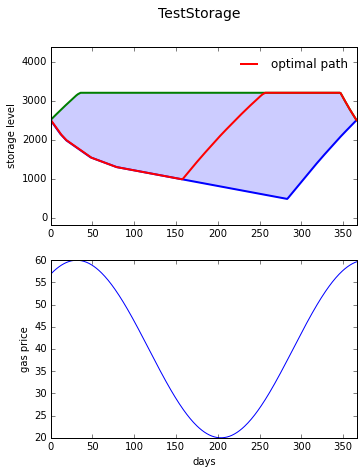

In [6]:
curve = 20*pd.Series(np.sin(np.linspace(0,10,len(dates))/1.5+1), index=dates)+40

storage.optimize(curve, curve)
storage.plot();

The optimal strategy depends on the gas price curve

...which we don't know...

...so we generate scenarios

In [7]:
from btglib.quant.models.simulator import Simulator

model_parameters = {'distribution': 'LogNormal',
                    'volatility': np.array([0.1]*len(dates))[:,None], 
                    'correlation': np.eye(1), 
                    'names': ['gas'],
                   }

simulator = Simulator('5-Jun-2015', dates, curve[:,None], model_parameters)
sims = simulator.generate_paths(100)

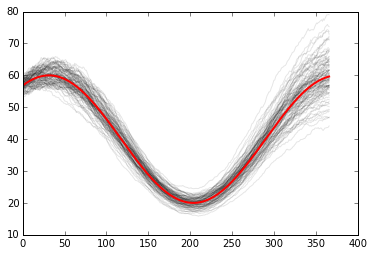

In [8]:
plt.plot(sims.ix[0,:,:], color='k', alpha=0.1);
plt.plot(curve, color='r', linewidth=2);

## Stochastic optimisation problem

* optimal strategy under uncertainty
* Monte-Carlo simulation with different distributions
* large optimisation problems
* price sensitivities

## Why Python?

* ideal for start-up
* quick cycle from idea to prototype to tool
* "batteries included" - scientific libraries, visualisation tools, documentation
* python may be slow...but cython (c/c++) is not!

## To trade complex products one first needs to be able to...trade!

In [9]:
trades = pd.DataFrame({'Product': ['WkEnd 04/07-05/', 'Q315', 'Aug 15'], 
                       'Market': ['Germany Baseload', 'Germany Peaks', 'Germany Baseload'], 
                       'Volume': [50, -10, 20]})

* Building an ETRM (Energy Trading and Risk Management system)
  - parse trades
  - calculate positions and PnL per trader/book/strategy
  - produce custom reports

In [10]:
trades

,Market,Product,Volume
0,Germany Baseload,WkEnd 04/07-05/,50
1,Germany Peaks,Q315,-10
2,Germany Baseload,Aug 15,20


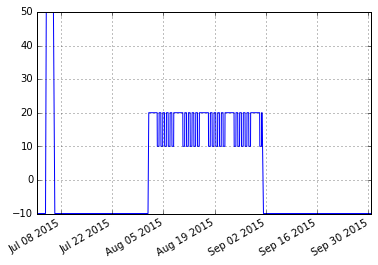

In [11]:
from btglib.utils import parse_traded_product

schedules = [parse_traded_product(p, m, datetime.now(), v) for p,m,v in trades[['Product','Market','Volume']].values]
position = pd.concat(schedules, axis=1).sum(axis=1)
position.plot();

## ETRM

* trade processing with <code>re</code>
* positions generation/aggregation with <code>pandas</code>
* reporting with <code>reportlab</code>
* interface with Excel using <code>pyxll</code>

## To protect downside risk...need to be able to trade options!
### (and to make money too)

<br>
* model for quick valuation of option portfolios
* display portfolio sensitivities
* pnl attribution
* scenario testing

All of these require an implied volatility surface

In [12]:
from IPython.display import HTML
HTML('<iframe src=http://data.theice.com/MyAccount/Login.aspx?ReturnUrl=~\ViewData\Default.aspx width=1060 height=550></iframe>')

## Web-scraping with Python

* <code>requests</code> for simple web pages
* <code>selenium</code> when we need to drive a web browser to navigate to the data
  - portable software testing framework for web applications
  - compatible with most modern browsers
  - bindings for a number of popular programming languages, including Python (and some others like Java, C#, Groovy, Perl, PHP and Ruby)
* <code>BeautifulSoup</code> to parse the data

In [13]:
from IPython.display import HTML
HTML('<iframe src=https://plot.ly/~tbaeva/98/vol-surface-25-feb-2015/ width=960 height=700></iframe>')

## Automation, reporting, alerting

* python is great for automating tasks to scrape data, process and produce model results
* ...but also to produce and send out custom reports
* reports can be built with <code>reportlab</code> and saved as pdf
* emailing is easy with <code>smtplib</code>

## Automation, reporting, alerting

* reading your Outlook to automatically process data (e.g. from brokers)

In [14]:
import win32com.client

outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")
inbox = outlook.GetDefaultFolder(6)
last_message = inbox.Items.GetLast()
print last_message.sender()
print last_message.subject

Yves Hilpisch
RE: OSQF Conference in Frankfurt 05.06.2015


## Deploying models to the desk

* traders love Excel
* python modules can be used from Excel, e.g. via <code>pyxll</code> (Tony Roberts)
* easy to centralise application modules and keep them under version control
* however...
  - requires python installation on trader's machine
  - package updates locally
  - ...and traders don't like rebooting

## Deploying models to the desk

* web interface
  - models are triggered from the browser
  - models run on a server
  - results displayed on browser
  - model runs can be logged
  - easy to embed interactive plotting!

## Web Interface

* built using <code>flask</code> and <code>jinja</code>
* allows to have interface, documentation, wiki etc in one place
* running via Apache

<img src='qpy1.png' width="800">

## Web Interface

* interactive plotting with <code>bokeh</code>
<br>
<br>

<img src='qpy2.png' width="800">

## Web Interface

* embedded pdf report created with <code>reportlab</code>
<br>
<br>

<img src='qpy3.png' width="800">

## In conclusion

* python is traditionally seen as a scientific language (scientific libraries)
* due to python's versatility and rich ecosystem it can be used to build a trading business from scratch
* full suite from data collection, to modelling, to visualisation, to automation, reporting and alerting, to great user interfaces

<br>
<img src='framework.png' width="800">

### thanks!

<img src='btg_disclaimer.png' width="1000">